Entrenando arquitectura=(32,), dropout_mask=(False,)
Entrenando arquitectura=(32,), dropout_mask=(True,)
Entrenando arquitectura=(64,), dropout_mask=(False,)
Entrenando arquitectura=(64,), dropout_mask=(True,)
Entrenando arquitectura=(128,), dropout_mask=(False,)
Entrenando arquitectura=(128,), dropout_mask=(True,)
Entrenando arquitectura=(256,), dropout_mask=(False,)
Entrenando arquitectura=(256,), dropout_mask=(True,)
Entrenando arquitectura=(32, 32), dropout_mask=(False, False)
Entrenando arquitectura=(32, 32), dropout_mask=(True, False)
Entrenando arquitectura=(32, 32), dropout_mask=(False, True)
Entrenando arquitectura=(32, 32), dropout_mask=(True, True)
Entrenando arquitectura=(32, 64), dropout_mask=(False, False)
Entrenando arquitectura=(32, 64), dropout_mask=(True, False)
Entrenando arquitectura=(32, 64), dropout_mask=(False, True)
Entrenando arquitectura=(32, 64), dropout_mask=(True, True)
Entrenando arquitectura=(32, 128), dropout_mask=(False, False)
Entrenando arquitectura=(

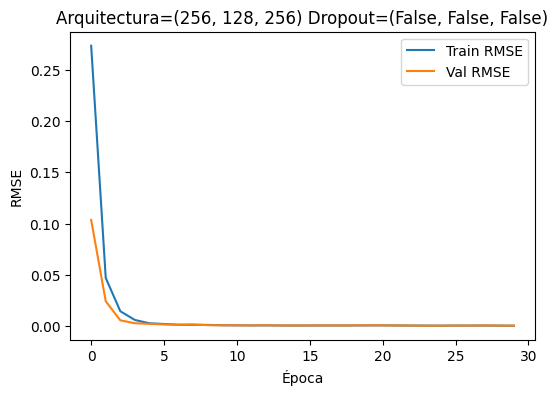

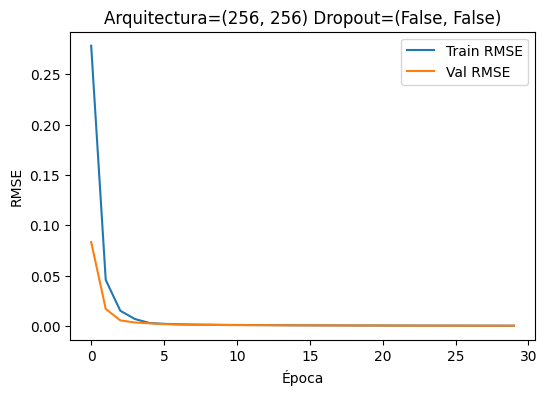

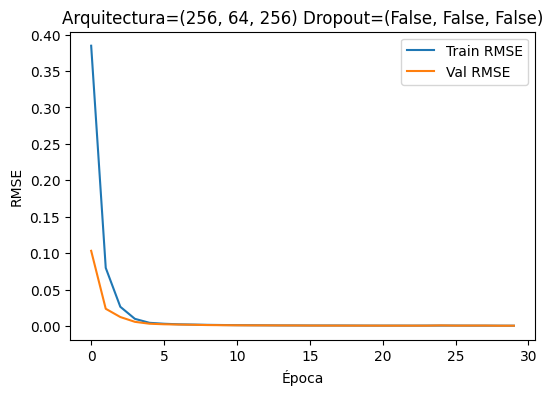

In [2]:
import numpy as np
import itertools
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# =========================
# 1. Datos de ejemplo
# =========================
t = np.linspace(0, 100, 1000)
serie = np.sin(t)

def crear_dataset(serie, window_size=10):
    X, y = [], []
    for i in range(len(serie) - window_size):
        X.append(serie[i:i+window_size])
        y.append(serie[i+window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = crear_dataset(serie, window_size)

# split en train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# =========================
# 2. Arquitecturas + Dropout
# =========================
neuronas = [32, 64, 128, 256]
max_capas = 3   # demo (sube a 3 o 4 si quieres)
arquitecturas = []
for num_capas in range(1, max_capas+1):
    for comb in itertools.product(neuronas, repeat=num_capas):
        arquitecturas.append(comb)

def dropout_configs(n_capas):
    for mask in range(2**n_capas):
        yield tuple(bool((mask >> i) & 1) for i in range(n_capas))

# =========================
# 3. Modelo
# =========================
def construir_modelo(arquitectura, dropout_mask, input_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    for idx, units in enumerate(arquitectura):
        model.add(tf.keras.layers.Dense(units, activation="relu"))
        if dropout_mask[idx]:
            model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# =========================
# 4. Loop con guardado de métricas y curvas
# =========================
resultados = []
epochs = 30

for arch in arquitecturas:
    for dmask in dropout_configs(len(arch)):
        print(f"Entrenando arquitectura={arch}, dropout_mask={dmask}")
        model = construir_modelo(arch, dmask, input_dim=window_size)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            verbose=0
        )

        train_rmse = history.history["root_mean_squared_error"]
        val_rmse = history.history["val_root_mean_squared_error"]

        best_val = np.min(val_rmse)
        last_train = train_rmse[-1]
        gap = abs(last_train - best_val)

        y_pred = model.predict(X_test, verbose=0)
        test_rmse = mean_squared_error(y_test, y_pred, squared=False)

        resultados.append({
            "arquitectura": arch,
            "dropout_mask": dmask,
            "best_val_rmse": best_val,
            "last_train_rmse": last_train,
            "gap": gap,
            "test_rmse": test_rmse,
            "train_curve": train_rmse,
            "val_curve": val_rmse
        })

# =========================
# 5. Selección automática
# =========================
df = pd.DataFrame(resultados)
df["gap_ratio"] = df["gap"] / df["best_val_rmse"]

candidatos = df[(df["gap_ratio"] < 0.15)].sort_values("best_val_rmse")

print("\nModelos candidatos (balanceados):")
print(candidatos[["arquitectura","dropout_mask","best_val_rmse","test_rmse"]].head())

# =========================
# 6. Graficar curvas de los mejores
# =========================
top_n = 3
for i, row in candidatos.head(top_n).iterrows():
    plt.figure(figsize=(6,4))
    plt.plot(row["train_curve"], label="Train RMSE")
    plt.plot(row["val_curve"], label="Val RMSE")
    plt.title(f"Arquitectura={row['arquitectura']} Dropout={row['dropout_mask']}")
    plt.xlabel("Época")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()